# Denoising Diffusion Implicit Model (DDIM) Training Pipeline 

## Setup

In [18]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np

# use which NVIDIA GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


2024-01-17 13:59:25.145026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 13:59:25.145048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data pipeline

In [19]:
image_size = (72, 64) 
batch_size = 32

Found 430 files belonging to 1 classes.
Using 344 files for training.
Using 86 files for validation.


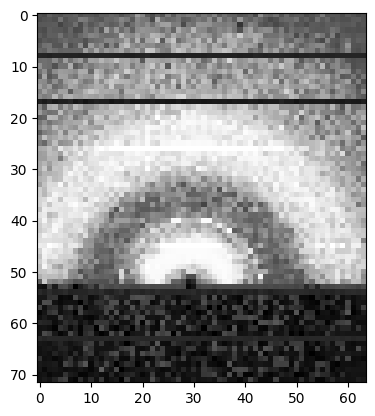

In [20]:
data_dir = './data/dataset'
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                                         labels=None, #if label='inferred', data_dir should be structured
                                                                         color_mode='rgb', #'grayscale',
                                                                         batch_size=batch_size,
                                                                         image_size=image_size,
                                                                         shuffle=True,
                                                                         seed=1,
                                                                         validation_split=0.2,
                                                                         subset='both',
                                                                         interpolation='lanczos5')    
    
# convert RGB to 3-channel grayscale to fullfil the diffusion model requirements
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32) 
val_dataset = val_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32)

plt.imshow(next(iter(train_dataset))[1])

## Model Configuration

In [26]:
from model_config import ModelConfig

model_config = ModelConfig(image_size=image_size, 
                           batch_size=batch_size)

## Training

In [24]:
from ddim import DiffusionModel
from utils import TrainCallbacks

num_epochs = 5  # train for at least 50 epochs for good results
learning_rate = 1e-3
weight_decay = 1e-4
checkpoint_path = "checkpoints/diffusion_model"
np = 5 # print an example image every n epochs during training

Epoch 1/5
10/10 [==============================] - ETA: 0s - n_loss: 0.7395 - i_loss: 2.9839scheduler_start_noise level 1.0
scheduler_start_noise level 1.0


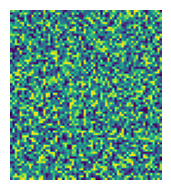

10/10 [==============================] - 52s 3s/step - n_loss: 0.7395 - i_loss: 2.9839 - val_n_loss: 0.7986 - val_i_loss: 3.3785 - val_kid: 1.8746
Epoch 2/5
10/10 [==============================] - 21s 2s/step - n_loss: 0.5045 - i_loss: 2.0543 - val_n_loss: 0.7990 - val_i_loss: 3.4722 - val_kid: 1.8519
Epoch 3/5
10/10 [==============================] - 15s 1s/step - n_loss: 0.3576 - i_loss: 1.1767 - val_n_loss: 0.7990 - val_i_loss: 3.4724 - val_kid: 1.8536
Epoch 4/5
10/10 [==============================] - 13s 1s/step - n_loss: 0.3163 - i_loss: 0.9542 - val_n_loss: 0.7991 - val_i_loss: 3.4726 - val_kid: 1.8530
Epoch 5/5
10/10 [==============================] - 12s 1s/step - n_loss: 0.2939 - i_loss: 0.7778 - val_n_loss: 0.7991 - val_i_loss: 3.4728 - val_kid: 1.8535
scheduler_start_noise level 1.0


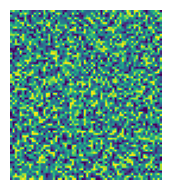

In [23]:
# create and compile the model
model = DiffusionModel(model_config)

model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    #optimizer=keras.optimizers.experimental.SGD(learning_rate=0.1, clipnorm=1.0),
    loss=keras.losses.mean_absolute_error,
)

# save the best model based on the validation KID metric
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)


# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# save log history
txt_log = open('ddim_train_logs.txt', mode='wt', buffering=1)
train_callbacks = TrainCallbacks(model=model, log_fn=txt_log, n=np)

# run training and plot generated images periodically
# source code: https://github.com/keras-team/keras/blob/master/keras/engine/training.py
# printing training results, then validation 
training= model.fit(
            train_dataset.take(len(train_dataset)-1),  # drop the last batch
            epochs=num_epochs,   
            validation_data=val_dataset.take(len(val_dataset)-1),
            callbacks=[
                keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: train_callbacks.fn_epoch_end(epoch, logs),
                    on_train_end = lambda epoch: train_callbacks.fn_train_end()                
                ),
                checkpoint_callback,
            ],
)

## Continue training from the saved checkpoint

**Note:** the training process starts with a new optimizer each time. This is because the optimizer states are not saved in the checkpoint.  However, we can observe the loss continue going down as the new training starts.

Epoch 1/5
10/10 [==============================] - ETA: 0s - n_loss: 0.2793 - i_loss: 0.6659scheduler_start_noise level 1.0


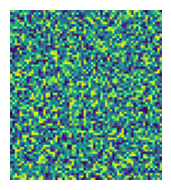

10/10 [==============================] - 13s 1s/step - n_loss: 0.2793 - i_loss: 0.6659 - val_n_loss: 0.7991 - val_i_loss: 3.4730 - val_kid: 1.8544
Epoch 2/5
10/10 [==============================] - 12s 1s/step - n_loss: 0.2670 - i_loss: 0.5997 - val_n_loss: 0.7992 - val_i_loss: 3.4731 - val_kid: 1.8547
Epoch 3/5
10/10 [==============================] - 13s 1s/step - n_loss: 0.2564 - i_loss: 0.5538 - val_n_loss: 0.7992 - val_i_loss: 3.4732 - val_kid: 1.8548
Epoch 4/5
10/10 [==============================] - 11s 1s/step - n_loss: 0.2538 - i_loss: 0.5329 - val_n_loss: 0.7992 - val_i_loss: 3.4733 - val_kid: 1.8554
Epoch 5/5
10/10 [==============================] - 11s 1s/step - n_loss: 0.2464 - i_loss: 0.5028 - val_n_loss: 0.7992 - val_i_loss: 3.4734 - val_kid: 1.8556
scheduler_start_noise level 1.0


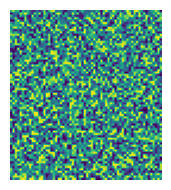

In [25]:
txt_log = open('ddim_train_logs.txt', mode='rt', buffering=1)
contents = "\n".join(map(lambda s: s.rstrip('\n'), txt_log.readlines()))
txt_log = open('ddim_train_logs.txt', mode='wt', buffering=1)
txt_log.write(contents+'\n')

train_callbacks = TrainCallbacks(model=model, log_fn=txt_log, n=np)

training2= model.fit(
            train_dataset.take(len(train_dataset)-1),  # drop the last batch
            epochs=num_epochs,   
            validation_data=val_dataset.take(len(val_dataset)-1),
            callbacks=[
                keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: train_callbacks.fn_epoch_end(epoch, logs),
                    on_train_end = lambda epoch: train_callbacks.fn_train_end()                  
                ),
                checkpoint_callback,
            ],
)